# Understanding Options Skew and Vanna

This notebook provides a computational demonstration of the concepts discussed in the provided transcript regarding derivatives markets, specifically focusing on **Skew**, **Spot-Vol Correlation**, and **Vanna** (the sensitivity of Delta to Volatility).

## Concepts Covered:
1.  **Spot-Vol Correlation:** The fundamental driver of equity skew.
2.  **The Skew Curve:** Visualizing the relationship between Strike Price and Implied Volatility.
3.  **The Risk Reversal:** Simulating the PnL of a Delta-Hedged portfolio under different market regimes.

### Prerequisites
We will use standard data science libraries (`numpy`, `pandas`, `matplotlib`) and `yfinance` to grab real market data.

In [1]:
# First, we import the necessary libraries.
# numpy: Used for fast math and arrays (like lists, but faster).
# pandas: Used for organizing data into tables (DataFrames).
# matplotlib: Used for drawing graphs.
# scipy.stats: Used for the normal distribution math needed for Black-Scholes.
# yfinance: Used to download free stock market data from Yahoo Finance.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf

# Dark mode styling inspired by UNC baseball dark jerseys
plt.style.use('dark_background')
plt.rcParams.update({
    'figure.facecolor': '#1B3A6B',
    'axes.facecolor': '#0F1F3A',
    'axes.edgecolor': '#4B9CD3',
    'axes.labelcolor': '#E8E8E8',
    'xtick.color': '#E8E8E8',
    'ytick.color': '#E8E8E8',
    'text.color': '#E8E8E8',
    'grid.color': '#2A4A6B',
    'grid.alpha': 0.3,
    'figure.figsize': (12, 6),
    'legend.facecolor': '#1B3A6B',
    'legend.edgecolor': '#4B9CD3',
    'legend.framealpha': 0.9,
})

--- 
## Part 1: Spot-Vol Correlation

**Content creator Benn Eifert says:** 
> *"What skew is driven by, first and foremost... is spot-vol correlation... In other words, how implied volatility tends to move as the underlying asset moves."*
> *"Why are equity markets characterized by downward sloping skew? It's because equity markets tend to get more volatile... when markets sell off."*

Let's prove this with data. We will compare the **S&P 500 (SPY)** against the **VIX (Volatility Index)**.

In [2]:
# Step 1: Download Data
# We are grabbing 5 years of data for 'SPY' (S&P 500 ETF) and '^VIX' (The fear index).
tickers = ['SPY', '^VIX']
# When downloading multiple tickers, yfinance returns a MultiIndex DataFrame
# Set auto_adjust=False to ensure we get 'Adj Close' as a separate column
raw_data = yf.download(tickers, start='2020-01-01', end='2024-01-01', auto_adjust=False)


[*********************100%***********************]  2 of 2 completed


Raw data shape: (1006, 12)

Column structure:
MultiIndex([('Adj Close',  'SPY'),
            ('Adj Close', '^VIX'),
            (    'Close',  'SPY'),
            (    'Close', '^VIX'),
            (     'High',  'SPY'),
            (     'High', '^VIX'),
            (      'Low',  'SPY'),
            (      'Low', '^VIX'),
            (     'Open',  'SPY'),
            (     'Open', '^VIX'),
            (   'Volume',  'SPY'),
            (   'Volume', '^VIX')],
           names=['Price', 'Ticker'])

First few rows:
Price        Adj Close              Close               High             \
Ticker             SPY   ^VIX         SPY   ^VIX         SPY       ^VIX   
Date                                                                      
2020-01-02  298.578644  12.47  324.869995  12.47  324.890015  13.720000   
2020-01-03  296.317719  14.02  322.410004  14.02  323.640015  16.200001   
2020-01-06  297.448181  13.85  323.640015  13.85  323.730011  16.389999   
2020-01-07  296.611908  13.7

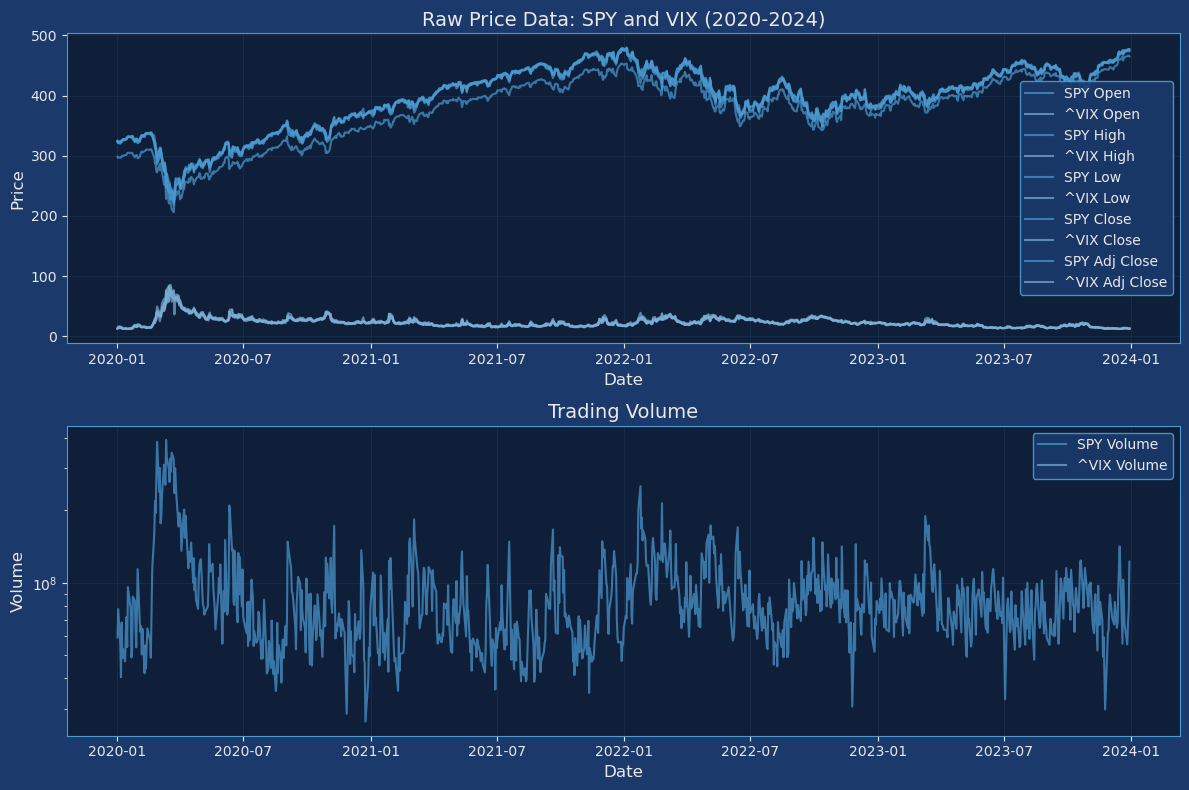

In [3]:
# Visualize the raw downloaded data structure
print("Raw data shape:", raw_data.shape)
print("\nColumn structure:")
print(raw_data.columns)
print("\nFirst few rows:")
print(raw_data.head())

# Visualize the data structure
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Color palette for dark mode
colors = {'SPY': '#4B9CD3', '^VIX': '#7BAFD4'}

# Plot all available price columns
if isinstance(raw_data.columns, pd.MultiIndex):
    level0_cols = raw_data.columns.get_level_values(0).unique()
    for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        if col in level0_cols:
            for ticker in tickers:
                if (col, ticker) in raw_data.columns:
                    color = colors.get(ticker, '#4B9CD3')
                    axes[0].plot(raw_data.index, raw_data[(col, ticker)], label=f'{ticker} {col}', alpha=0.7, color=color)
else:
    for col in raw_data.columns:
        axes[0].plot(raw_data.index, raw_data[col], label=col, alpha=0.7, color='#4B9CD3')

axes[0].set_title('Raw Price Data: SPY and VIX (2020-2024)', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Show volume data if available
if isinstance(raw_data.columns, pd.MultiIndex):
    if 'Volume' in level0_cols:
        for ticker in tickers:
            if ('Volume', ticker) in raw_data.columns:
                color = colors.get(ticker, '#4B9CD3')
                axes[1].plot(raw_data.index, raw_data[('Volume', ticker)], label=f'{ticker} Volume', alpha=0.7, color=color)
else:
    if 'Volume' in raw_data.columns:
        axes[1].plot(raw_data.index, raw_data['Volume'], label='Volume', alpha=0.7, color='#4B9CD3')

axes[1].set_title('Trading Volume', fontsize=14)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('Volume', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()


In [4]:
# Step 2: Extract 'Adj Close' column from the MultiIndex
# Handle different possible column structures
if isinstance(raw_data.columns, pd.MultiIndex):
    # Check what columns are available at level 0
    level0_cols = raw_data.columns.get_level_values(0).unique()
    # Try 'Adj Close' first, fall back to 'Close' if not available
    if 'Adj Close' in level0_cols:
        data = raw_data.xs('Adj Close', level=0, axis=1)
    elif 'Close' in level0_cols:
        data = raw_data.xs('Close', level=0, axis=1)
    else:
        # If neither exists, try direct access or use the first numeric column
        print(f"Available columns: {level0_cols}")
        raise KeyError("Could not find 'Adj Close' or 'Close' in downloaded data")
else:
    # Single level columns - try 'Adj Close' first, then 'Close'
    if 'Adj Close' in raw_data.columns:
        data = raw_data['Adj Close']
    elif 'Close' in raw_data.columns:
        data = raw_data['Close']
    else:
        print(f"Available columns: {raw_data.columns.tolist()}")
        raise KeyError("Could not find 'Adj Close' or 'Close' in downloaded data")

print("Extracted price data shape:", data.shape)
print("\nFirst few rows of extracted data:")
print(data.head())
print("\nData statistics:")
print(data.describe())


Extracted price data shape: (1006, 2)

First few rows of extracted data:
Ticker             SPY   ^VIX
Date                         
2020-01-02  298.578644  12.47
2020-01-03  296.317719  14.02
2020-01-06  297.448181  13.85
2020-01-07  296.611908  13.79
2020-01-08  298.192719  13.45

Data statistics:
Ticker          SPY         ^VIX
count   1006.000000  1006.000000
mean     375.859815    22.865905
std       53.615592     8.484276
min      206.111877    12.070000
25%      345.480652    17.280001
50%      388.842453    21.389999
75%      417.617218    26.292500
max      466.564575    82.690002


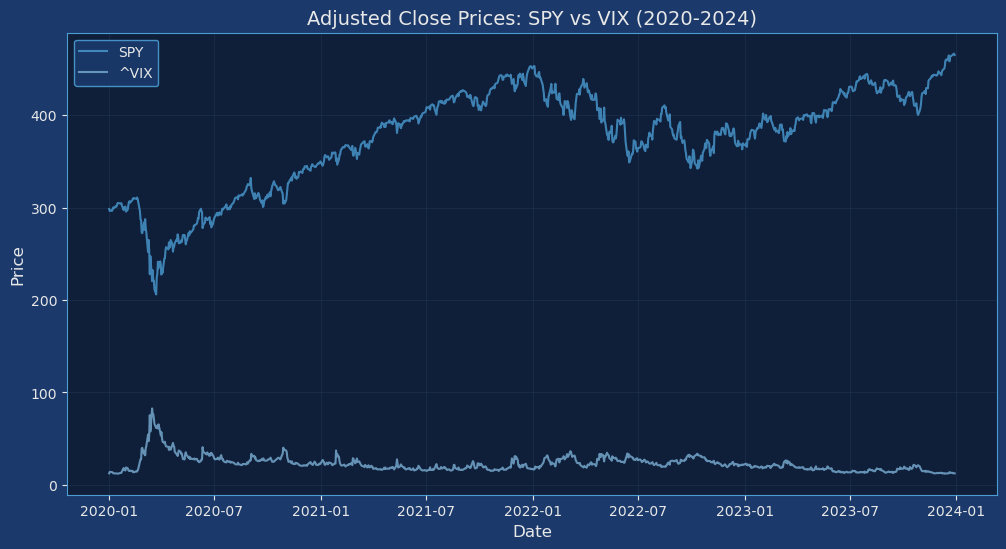

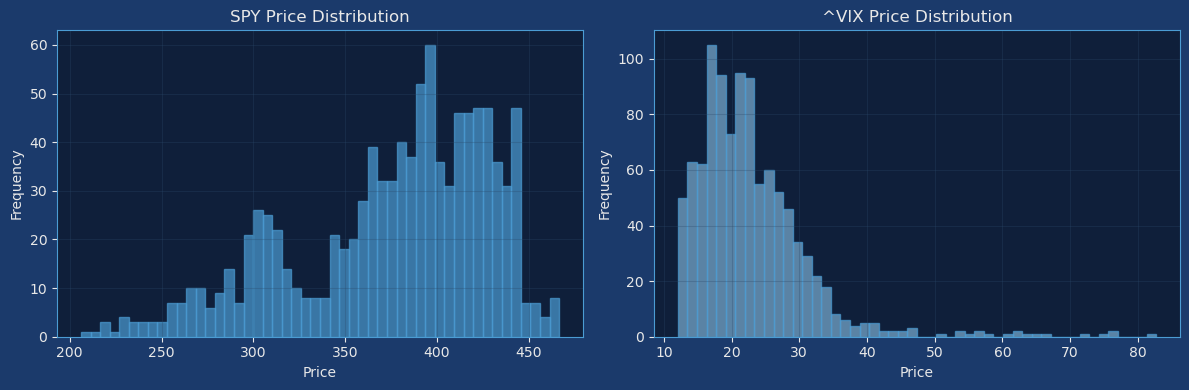

In [5]:
# Visualize the extracted price data over time
plt.figure(figsize=(12, 6))
colors = {'SPY': '#4B9CD3', '^VIX': '#7BAFD4'}
for col in data.columns:
    color = colors.get(col, '#4B9CD3')
    plt.plot(data.index, data[col], label=col, linewidth=1.5, alpha=0.8, color=color)

plt.title('Adjusted Close Prices: SPY vs VIX (2020-2024)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show price distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for idx, col in enumerate(data.columns):
    color = colors.get(col, '#4B9CD3')
    axes[idx].hist(data[col].dropna(), bins=50, alpha=0.7, edgecolor='#4B9CD3', color=color)
    axes[idx].set_title(f'{col} Price Distribution', fontsize=12)
    axes[idx].set_xlabel('Price', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
# Step 3: Calculate "Returns"
# Returns are just the percentage change from one day to the next.
# If SPY goes from $400 to $404, that is a +1% return.
# We use log returns for better mathematical properties, but simple % change is fine too.
returns = np.log(data / data.shift(1)).dropna()

print("Returns data shape:", returns.shape)
print("\nFirst few rows of returns:")
print(returns.head())
print("\nReturns statistics:")
print(returns.describe())


Returns data shape: (1005, 2)

First few rows of returns:
Ticker           SPY      ^VIX
Date                          
2020-01-03 -0.007601  0.117159
2020-01-06  0.003808 -0.012200
2020-01-07 -0.002815 -0.004342
2020-01-08  0.005315 -0.024965
2020-01-09  0.006757 -0.070056

Returns statistics:
Ticker          SPY         ^VIX
count   1005.000000  1005.000000
mean       0.000441    -0.000002
std        0.014315     0.076474
min       -0.115887    -0.266228
25%       -0.005731    -0.044067
50%        0.000841    -0.008494
75%        0.007619     0.034686
max        0.086731     0.480214


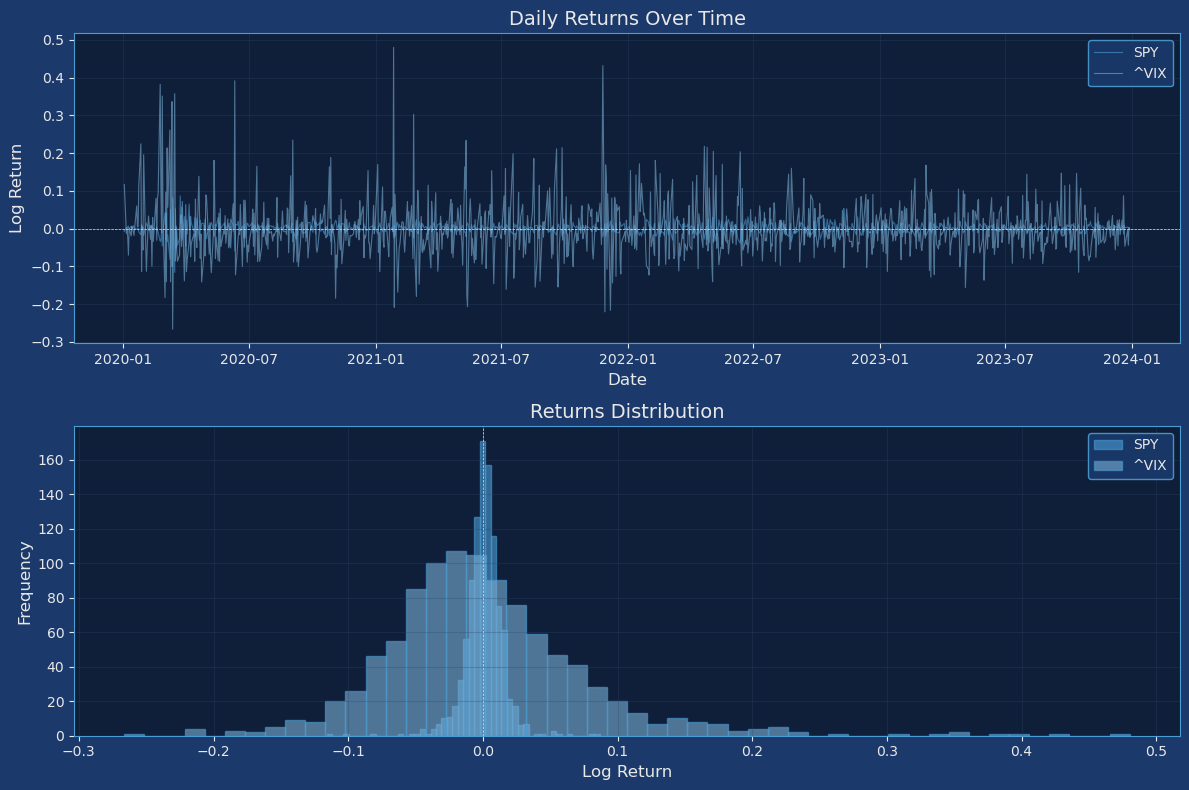

In [7]:
# Visualize returns over time
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Color palette
colors = {'SPY': '#4B9CD3', '^VIX': '#7BAFD4'}

# Plot returns time series
for col in returns.columns:
    color = colors.get(col, '#4B9CD3')
    axes[0].plot(returns.index, returns[col], label=col, alpha=0.6, linewidth=0.8, color=color)

axes[0].axhline(0, color='#E8E8E8', linewidth=0.5, linestyle='--')
axes[0].set_title('Daily Returns Over Time', fontsize=14)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Log Return', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot returns distribution
for col in returns.columns:
    color = colors.get(col, '#4B9CD3')
    axes[1].hist(returns[col].dropna(), bins=50, alpha=0.6, label=col, edgecolor='#4B9CD3', color=color)

axes[1].axvline(0, color='#E8E8E8', linewidth=0.5, linestyle='--')
axes[1].set_title('Returns Distribution', fontsize=14)
axes[1].set_xlabel('Log Return', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


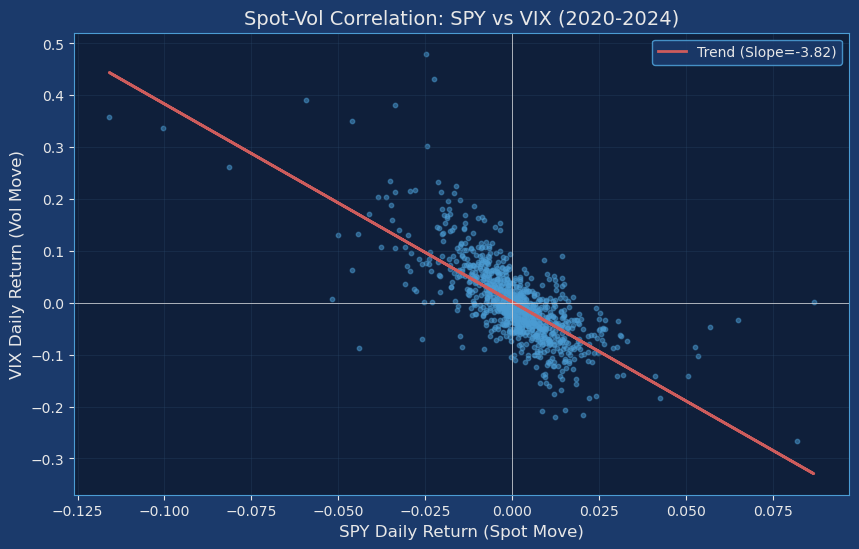

Correlation between SPY and VIX: -0.71
INTERPRETATION: A strong negative number means when the market drops, fear (Vol) spikes.


In [8]:
# Step 4: Analyze the Relationship
# We want to see: When SPY goes DOWN (negative x-axis), does VIX go UP (positive y-axis)?

plt.figure(figsize=(10, 6))

# Scatter plot: Put SPY returns on X-axis, VIX returns on Y-axis
plt.scatter(returns['SPY'], returns['^VIX'], alpha=0.5, s=10, color='#4B9CD3')

# Add labels
plt.title('Spot-Vol Correlation: SPY vs VIX (2020-2024)', fontsize=14)
plt.xlabel('SPY Daily Return (Spot Move)', fontsize=12)
plt.ylabel('VIX Daily Return (Vol Move)', fontsize=12)

# Add a trend line to show the slope
m, b = np.polyfit(returns['SPY'], returns['^VIX'], 1)
plt.plot(returns['SPY'], m*returns['SPY'] + b, color='#CD5C5C', linewidth=2, label=f'Trend (Slope={m:.2f})')

plt.legend()
plt.axhline(0, color='#E8E8E8', linewidth=0.5)
plt.axvline(0, color='#E8E8E8', linewidth=0.5)
plt.grid(True, alpha=0.3)
plt.show()

# Calculate the correlation coefficient (a number between -1 and 1)
correlation = returns['SPY'].corr(returns['^VIX'])
print(f"Correlation between SPY and VIX: {correlation:.2f}")
print("INTERPRETATION: A strong negative number means when the market drops, fear (Vol) spikes.")


--- 
## Part 2: Visualizing the Skew Curve

**Content creator Benn Eifert says:**
> *"It refers to the shape, the slope of the function that relates strike price... and implied volatility on the y-axis."*
> *"In equity markets... you would typically expect predominantly a downward sloping skew curve."*
> *"Assets like Gold, Oil, or Bitcoin often have a 'smile' or upward slope."*

Let's compare the skew curves for different asset classes. We'll look at:
- **SPY (S&P 500 ETF)**: Equity markets with downward-sloping "smirk"
- **GLD (Gold ETF)**: Commodity markets with symmetric "smile"

We'll normalize by **Moneyness** (Strike/Spot) to compare them fairly.

In [9]:
# Step 1: Get Option Chains for Both Assets
spy = yf.Ticker("SPY")
gld = yf.Ticker("GLD")

# Get available expiration dates for SPY
print("=== SPY Option Expirations ===")
print("Available expiration dates:")
print(spy.options[:10])  # Show first 10
print(f"Total available expirations: {len(spy.options)}")

# Get available expiration dates for GLD
print("\n=== GLD Option Expirations ===")
print("Available expiration dates:")
print(gld.options[:10])  # Show first 10
print(f"Total available expirations: {len(gld.options)}")

=== SPY Option Expirations ===
Available expiration dates:
('2025-11-24', '2025-11-25', '2025-11-26', '2025-11-28', '2025-12-01', '2025-12-02', '2025-12-03', '2025-12-04', '2025-12-05', '2025-12-12')
Total available expirations: 31

=== GLD Option Expirations ===
Available expiration dates:
('2025-11-24', '2025-11-26', '2025-11-28', '2025-12-01', '2025-12-03', '2025-12-05', '2025-12-12', '2025-12-19', '2025-12-26', '2025-12-31')
Total available expirations: 24


In [10]:
# Step 2: Select expiration dates and get option chains for both assets
# We pick an expiration date a few weeks/months out to get a clean curve.
# We take the 4th available expiration date just to be safe.
try:
    expiration_spy = spy.options[4]
    expiration_gld = gld.options[4] if len(gld.options) > 4 else gld.options[0]
    
    print(f"Selected SPY expiration date: {expiration_spy}")
    print(f"Selected GLD expiration date: {expiration_gld}")
    
    chain_spy = spy.option_chain(expiration_spy)
    chain_gld = gld.option_chain(expiration_gld)
    
    # Get current prices to determine "Moneyness"
    current_price_spy = spy.history(period='1d')['Close'].iloc[-1]
    current_price_gld = gld.history(period='1d')['Close'].iloc[-1]
    
    print(f"\nCurrent SPY price: ${current_price_spy:.2f}")
    print(f"Current GLD price: ${current_price_gld:.2f}")
    
except Exception as e:
    print(f"Could not retrieve option data (Market might be closed or API issue): {e}")
    expiration_spy = None
    expiration_gld = None
    chain_spy = None
    chain_gld = None
    current_price_spy = None
    current_price_gld = None


Selected SPY expiration date: 2025-12-01
Selected GLD expiration date: 2025-12-03

Current SPY price: $659.03
Current GLD price: $374.27


In [11]:
# Step 3: Extract Calls and Puts data for both assets
# Skew is often looked at by comparing OTM Puts (Strikes < Price) and OTM Calls (Strikes > Price)

# SPY data
if chain_spy is not None:
    calls_spy = chain_spy.calls
    puts_spy = chain_spy.puts
    print("=== SPY Option Data ===")
    print(f"Calls data shape: {calls_spy.shape}")
    print(f"Puts data shape: {puts_spy.shape}")
else:
    calls_spy = None
    puts_spy = None

# GLD data
if chain_gld is not None:
    calls_gld = chain_gld.calls
    puts_gld = chain_gld.puts
    print("\n=== GLD Option Data ===")
    print(f"Calls data shape: {calls_gld.shape}")
    print(f"Puts data shape: {puts_gld.shape}")
else:
    calls_gld = None
    puts_gld = None


=== SPY Option Data ===
Calls data shape: (111, 14)
Puts data shape: (100, 14)

=== GLD Option Data ===
Calls data shape: (53, 14)
Puts data shape: (53, 14)


In [12]:
# Step 4: Filter for liquid options (volume > 10) and remove NaN IVs
# SPY filtering
if calls_spy is not None and puts_spy is not None:
    calls_spy_filtered = calls_spy[(calls_spy['volume'] > 10) & (calls_spy['impliedVolatility'].notna())].copy()
    puts_spy_filtered = puts_spy[(puts_spy['volume'] > 10) & (puts_spy['impliedVolatility'].notna())].copy()
    print(f"\n=== SPY Filtered Data ===")
    print(f"Calls: {len(calls_spy_filtered)} options")
    print(f"Puts: {len(puts_spy_filtered)} options")
else:
    calls_spy_filtered = None
    puts_spy_filtered = None

# GLD filtering
if calls_gld is not None and puts_gld is not None:
    calls_gld_filtered = calls_gld[(calls_gld['volume'] > 10) & (calls_gld['impliedVolatility'].notna())].copy()
    puts_gld_filtered = puts_gld[(puts_gld['volume'] > 10) & (puts_gld['impliedVolatility'].notna())].copy()
    print(f"\n=== GLD Filtered Data ===")
    print(f"Calls: {len(calls_gld_filtered)} options")
    print(f"Puts: {len(puts_gld_filtered)} options")
else:
    calls_gld_filtered = None
    puts_gld_filtered = None



=== SPY Filtered Data ===
Calls: 59 options
Puts: 74 options

=== GLD Filtered Data ===
Calls: 17 options
Puts: 20 options


In [13]:
# Step 5: Calculate Moneyness and Prepare Data for Comparison
# Moneyness = Strike / Spot Price
# This allows us to compare assets with different absolute price levels

def prepare_skew_data(calls_df, puts_df, spot_price, asset_name):
    """Prepare option data with moneyness for plotting"""
    if calls_df is None or puts_df is None or spot_price is None:
        return None, None, None, None
    
    # Combine calls and puts, calculate moneyness
    calls_data = calls_df[['strike', 'impliedVolatility']].copy()
    calls_data['moneyness'] = calls_data['strike'] / spot_price
    calls_data['type'] = 'Call'
    
    puts_data = puts_df[['strike', 'impliedVolatility']].copy()
    puts_data['moneyness'] = puts_data['strike'] / spot_price
    puts_data['type'] = 'Put'
    
    # Combine
    all_data = pd.concat([calls_data, puts_data], ignore_index=True)
    
    return calls_data, puts_data, all_data, spot_price

# Prepare SPY data
calls_spy_data, puts_spy_data, all_spy_data, spot_spy = prepare_skew_data(
    calls_spy_filtered, puts_spy_filtered, current_price_spy, 'SPY'
)

# Prepare GLD data
calls_gld_data, puts_gld_data, all_gld_data, spot_gld = prepare_skew_data(
    calls_gld_filtered, puts_gld_filtered, current_price_gld, 'GLD'
)

print("\n=== Data Preparation Complete ===")
if all_spy_data is not None:
    print(f"SPY: {len(all_spy_data)} options, Spot: ${spot_spy:.2f}")
if all_gld_data is not None:
    print(f"GLD: {len(all_gld_data)} options, Spot: ${spot_gld:.2f}")



=== Data Preparation Complete ===
SPY: 133 options, Spot: $659.03
GLD: 37 options, Spot: $374.27


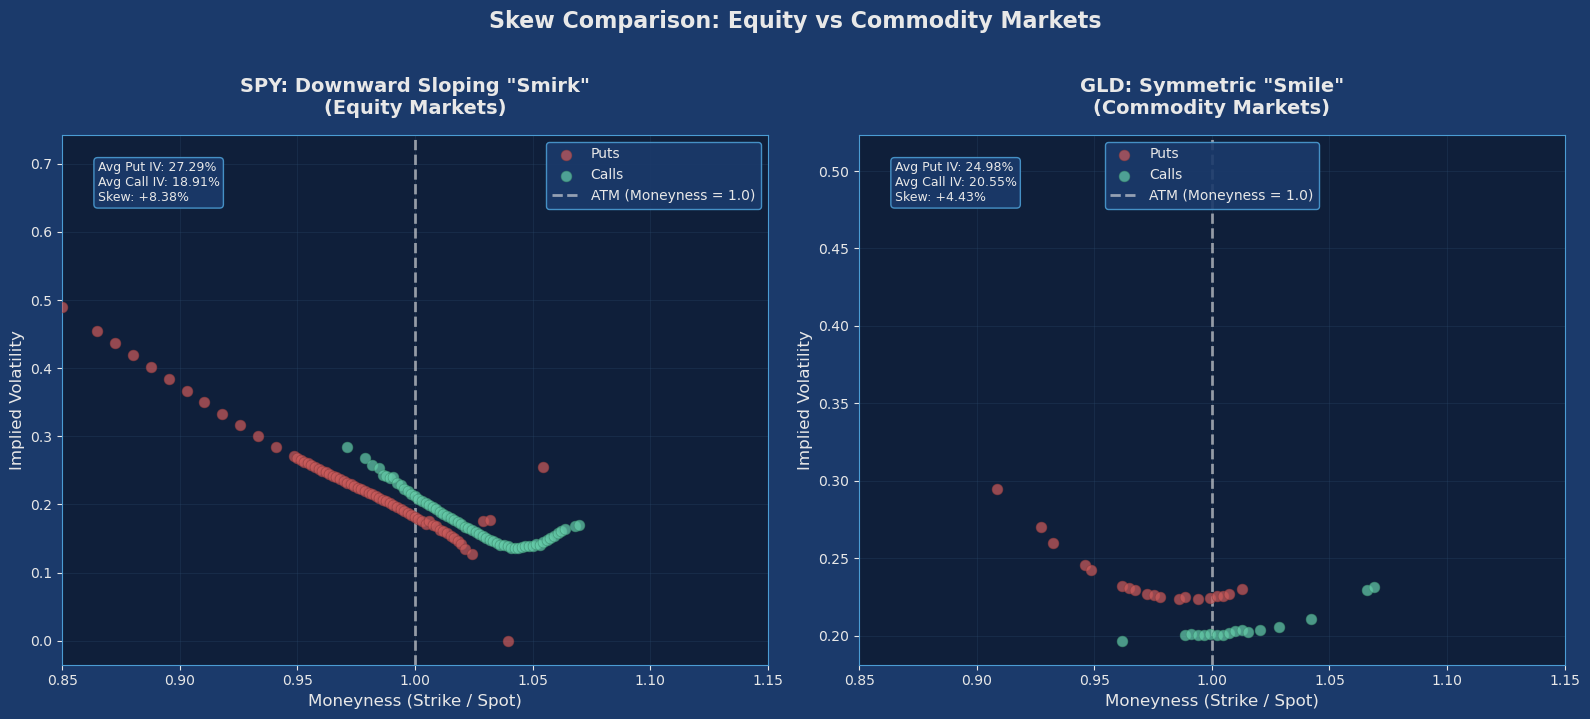


OBSERVATIONS:

SPY (Equity - Downward Sloping 'Smirk'):
  • OTM Puts (left side) have HIGHER implied volatility
  • OTM Calls (right side) have LOWER implied volatility
  • This reflects the market's expectation that equity markets
    get more volatile when they sell off (negative spot-vol correlation)

GLD (Commodity - Symmetric 'Smile'):
  • Both OTM Puts AND OTM Calls have higher volatility than ATM
  • The curve is more symmetric, forming a 'smile' shape
  • This reflects different risk dynamics in commodity markets
    where volatility can increase in both directions


In [14]:
# Step 6: Create Side-by-Side Comparison Plot
# Normalized by Moneyness (Strike/Spot) for fair comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# === LEFT PLOT: SPY Skew (Downward Sloping "Smirk") ===
if all_spy_data is not None and spot_spy is not None:
    ax_left = axes[0]
    
    # Plot Puts (OTM puts = lower moneyness)
    if puts_spy_data is not None and len(puts_spy_data) > 0:
        ax_left.scatter(puts_spy_data['moneyness'], puts_spy_data['impliedVolatility'], 
                       s=60, label='Puts', alpha=0.7, color='#CD5C5C', edgecolors='#8B3A3A', linewidth=0.5, zorder=3)
    
    # Plot Calls (OTM calls = higher moneyness)
    if calls_spy_data is not None and len(calls_spy_data) > 0:
        ax_left.scatter(calls_spy_data['moneyness'], calls_spy_data['impliedVolatility'], 
                       s=60, label='Calls', alpha=0.7, color='#66CDAA', edgecolors='#3A8B6B', linewidth=0.5, zorder=3)
    
    # Mark ATM (moneyness = 1.0)
    ax_left.axvline(1.0, color='#E8E8E8', linestyle='--', linewidth=2, alpha=0.6, label='ATM (Moneyness = 1.0)')
    
    ax_left.set_title(f'SPY: Downward Sloping "Smirk"\n(Equity Markets)', 
                     fontsize=14, fontweight='bold', pad=15)
    ax_left.set_xlabel('Moneyness (Strike / Spot)', fontsize=12)
    ax_left.set_ylabel('Implied Volatility', fontsize=12)
    ax_left.legend(fontsize=10, loc='upper right')
    ax_left.grid(True, alpha=0.3)
    ax_left.set_xlim(0.85, 1.15)
    
    # Calculate and display skew statistics
    if puts_spy_data is not None and calls_spy_data is not None:
        if len(puts_spy_data) > 0 and len(calls_spy_data) > 0:
            avg_put_iv = puts_spy_data['impliedVolatility'].mean()
            avg_call_iv = calls_spy_data['impliedVolatility'].mean()
            skew_value = avg_put_iv - avg_call_iv
            textstr = f'Avg Put IV: {avg_put_iv:.2%}\nAvg Call IV: {avg_call_iv:.2%}\nSkew: {skew_value:+.2%}'
            props = dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#4B9CD3', linewidth=1)
            ax_left.text(0.05, 0.95, textstr, transform=ax_left.transAxes, fontsize=9,
                        verticalalignment='top', bbox=props, color='#E8E8E8')

# === RIGHT PLOT: GLD Skew (Symmetric "Smile") ===
if all_gld_data is not None and spot_gld is not None:
    ax_right = axes[1]
    
    # Plot Puts (OTM puts = lower moneyness)
    if puts_gld_data is not None and len(puts_gld_data) > 0:
        ax_right.scatter(puts_gld_data['moneyness'], puts_gld_data['impliedVolatility'], 
                        s=60, label='Puts', alpha=0.7, color='#CD5C5C', edgecolors='#8B3A3A', linewidth=0.5, zorder=3)
    
    # Plot Calls (OTM calls = higher moneyness)
    if calls_gld_data is not None and len(calls_gld_data) > 0:
        ax_right.scatter(calls_gld_data['moneyness'], calls_gld_data['impliedVolatility'], 
                        s=60, label='Calls', alpha=0.7, color='#66CDAA', edgecolors='#3A8B6B', linewidth=0.5, zorder=3)
    
    # Mark ATM (moneyness = 1.0)
    ax_right.axvline(1.0, color='#E8E8E8', linestyle='--', linewidth=2, alpha=0.6, label='ATM (Moneyness = 1.0)')
    
    ax_right.set_title(f'GLD: Symmetric "Smile"\n(Commodity Markets)', 
                       fontsize=14, fontweight='bold', pad=15)
    ax_right.set_xlabel('Moneyness (Strike / Spot)', fontsize=12)
    ax_right.set_ylabel('Implied Volatility', fontsize=12)
    ax_right.legend(fontsize=10, loc='upper center')
    ax_right.grid(True, alpha=0.3)
    ax_right.set_xlim(0.85, 1.15)
    
    # Calculate and display skew statistics
    if puts_gld_data is not None and calls_gld_data is not None:
        if len(puts_gld_data) > 0 and len(calls_gld_data) > 0:
            avg_put_iv = puts_gld_data['impliedVolatility'].mean()
            avg_call_iv = calls_gld_data['impliedVolatility'].mean()
            skew_value = avg_put_iv - avg_call_iv
            textstr = f'Avg Put IV: {avg_put_iv:.2%}\nAvg Call IV: {avg_call_iv:.2%}\nSkew: {skew_value:+.2%}'
            props = dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#4B9CD3', linewidth=1)
            ax_right.text(0.05, 0.95, textstr, transform=ax_right.transAxes, fontsize=9,
                         verticalalignment='top', bbox=props, color='#E8E8E8')

plt.suptitle('Skew Comparison: Equity vs Commodity Markets', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print observations
print("\n" + "="*60)
print("OBSERVATIONS:")
print("="*60)
if all_spy_data is not None:
    print("\nSPY (Equity - Downward Sloping 'Smirk'):")
    print("  • OTM Puts (left side) have HIGHER implied volatility")
    print("  • OTM Calls (right side) have LOWER implied volatility")
    print("  • This reflects the market's expectation that equity markets")
    print("    get more volatile when they sell off (negative spot-vol correlation)")
    
if all_gld_data is not None:
    print("\nGLD (Commodity - Symmetric 'Smile'):")
    print("  • Both OTM Puts AND OTM Calls have higher volatility than ATM")
    print("  • The curve is more symmetric, forming a 'smile' shape")
    print("  • This reflects different risk dynamics in commodity markets")
    print("    where volatility can increase in both directions")
print("="*60)


--- 
## Part 2.5: Sticky Strike vs. Sticky Delta

**Understanding Volatility Skew Dynamics**

When the spot price moves, how does the volatility skew curve respond? There are two main paradigms:

1. **Sticky Strike (Fixed Strike):** The implied volatility for a specific strike price (e.g., Strike 100) remains constant even as the spot price moves. The curve stays "fixed" in strike space.

2. **Sticky Delta (Floating Strike):** The volatility curve shifts sideways with the spot price. The new At-The-Money (ATM) strike inherits the old ATM volatility, maintaining the same volatility structure relative to moneyness.

This distinction is crucial for understanding how equity markets behave during sell-offs, as mentioned in the transcript:
> *"Equity markets tend to get more volatile when markets sell off."*

Let's visualize both scenarios with a 5% drop in the spot price.


In [15]:
# Step 1: Create a realistic volatility skew curve
# We'll model a downward-sloping skew typical of equity markets
# ATM vol is lower, OTM puts (lower strikes) have higher vol

# Initial parameters
S0 = 100.0  # Initial spot price
S_new = S0 * 0.95  # 5% drop: new spot = 95

# Create strike range
strikes = np.linspace(70, 130, 61)  # Strikes from 70 to 130

# Model a realistic skew curve: higher vol for lower strikes (OTM puts)
# Using a simple linear + exponential decay model
def create_skew_curve(strikes, spot, atm_vol=0.20):
    """
    Create a downward-sloping volatility skew curve.
    ATM vol is at the spot price, lower strikes have higher vol.
    """
    # Calculate moneyness (strike/spot)
    moneyness = strikes / spot
    
    # Create skew: higher vol for lower moneyness (OTM puts)
    # Base vol increases as we go further OTM on the put side
    skew_factor = 0.15 * np.exp(-2 * (moneyness - 1)**2)  # Peak at ATM, decays away
    put_skew = 0.08 * np.maximum(0, 1 - moneyness)  # Extra vol for OTM puts
    
    vol_curve = atm_vol + skew_factor + put_skew
    return vol_curve

# Initial volatility curve
iv_initial = create_skew_curve(strikes, S0, atm_vol=0.20)

# Find ATM strike index (closest to spot)
atm_idx_initial = np.argmin(np.abs(strikes - S0))
atm_vol_initial = iv_initial[atm_idx_initial]

print(f"Initial Spot Price: ${S0:.2f}")
print(f"New Spot Price (5% drop): ${S_new:.2f}")
print(f"Initial ATM Volatility: {atm_vol_initial:.2%}")
print(f"Initial ATM Strike: ${strikes[atm_idx_initial]:.2f}")


Initial Spot Price: $100.00
New Spot Price (5% drop): $95.00
Initial ATM Volatility: 35.00%
Initial ATM Strike: $100.00


In [16]:
# Step 2: Sticky Strike - IV stays constant at each strike
# When spot moves, the IV at each strike price remains unchanged
iv_sticky_strike = iv_initial.copy()  # Same IV curve

# Find new ATM strike (closest to new spot)
atm_idx_new = np.argmin(np.abs(strikes - S_new))
atm_vol_new_sticky_strike = iv_sticky_strike[atm_idx_new]

print("=== STICKY STRIKE (Fixed Strike) ===")
print(f"After 5% drop:")
print(f"  New Spot: ${S_new:.2f}")
print(f"  New ATM Strike: ${strikes[atm_idx_new]:.2f}")
print(f"  IV at Strike ${strikes[atm_idx_new]:.2f}: {atm_vol_new_sticky_strike:.2%}")
print(f"  IV at Strike ${S0:.2f} (old ATM): {iv_sticky_strike[atm_idx_initial]:.2%}")
print(f"\nKey Point: IV at each strike price remains constant.")
print(f"  Strike ${S0:.2f} still has {iv_sticky_strike[atm_idx_initial]:.2%} IV")
print(f"  Strike ${strikes[atm_idx_new]:.2f} (new ATM) has {atm_vol_new_sticky_strike:.2%} IV")


=== STICKY STRIKE (Fixed Strike) ===
After 5% drop:
  New Spot: $95.00
  New ATM Strike: $95.00
  IV at Strike $95.00: 35.33%
  IV at Strike $100.00 (old ATM): 35.00%

Key Point: IV at each strike price remains constant.
  Strike $100.00 still has 35.00% IV
  Strike $95.00 (new ATM) has 35.33% IV


In [17]:
# Step 3: Sticky Delta - Curve shifts sideways
# The new ATM strike inherits the old ATM volatility
# We need to shift the curve so that the moneyness structure is preserved

# Calculate moneyness for initial curve
moneyness_initial = strikes / S0

# For sticky delta, we want the same vol structure relative to moneyness
# So we create a new curve based on the new spot, maintaining the same moneyness-vol relationship
iv_sticky_delta = create_skew_curve(strikes, S_new, atm_vol=atm_vol_initial)

# The key: new ATM should have the old ATM vol
# Adjust the curve to ensure this
iv_sticky_delta = iv_sticky_delta * (atm_vol_initial / iv_sticky_delta[atm_idx_new])

atm_vol_new_sticky_delta = iv_sticky_delta[atm_idx_new]

print("=== STICKY DELTA (Floating Strike) ===")
print(f"After 5% drop:")
print(f"  New Spot: ${S_new:.2f}")
print(f"  New ATM Strike: ${strikes[atm_idx_new]:.2f}")
print(f"  IV at New ATM Strike: {atm_vol_new_sticky_delta:.2%}")
print(f"  IV at Strike ${S0:.2f} (old ATM, now OTM call): {iv_sticky_delta[atm_idx_initial]:.2%}")
print(f"\nKey Point: The curve shifts sideways with the spot.")
print(f"  New ATM (${strikes[atm_idx_new]:.2f}) inherits old ATM vol: {atm_vol_new_sticky_delta:.2%}")
print(f"  Old ATM (${S0:.2f}) now has lower vol: {iv_sticky_delta[atm_idx_initial]:.2%} (it's now an OTM call)")


=== STICKY DELTA (Floating Strike) ===
After 5% drop:
  New Spot: $95.00
  New ATM Strike: $95.00
  IV at New ATM Strike: 35.00%
  IV at Strike $100.00 (old ATM, now OTM call): 34.94%

Key Point: The curve shifts sideways with the spot.
  New ATM ($95.00) inherits old ATM vol: 35.00%
  Old ATM ($100.00) now has lower vol: 34.94% (it's now an OTM call)


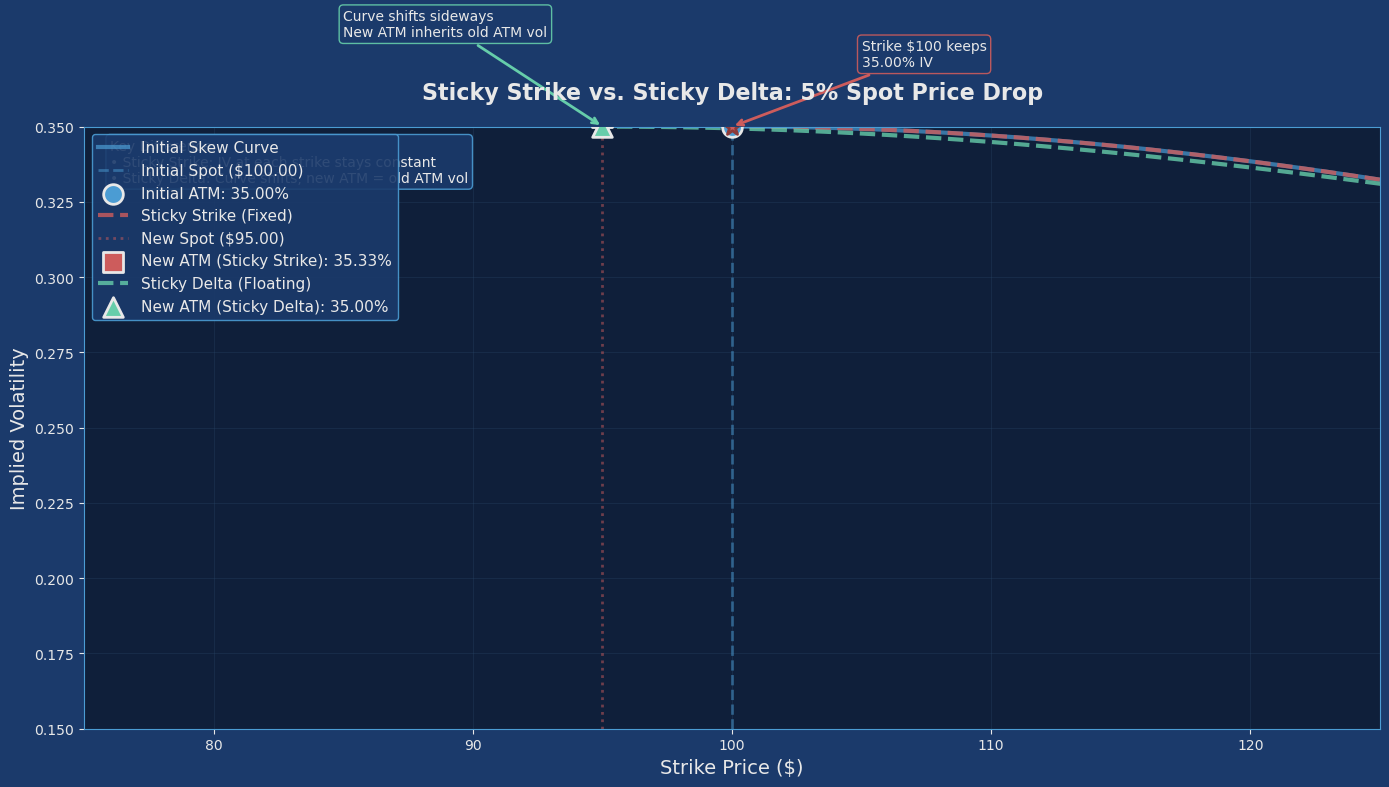

In [18]:
# Step 4: Create the visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot initial curve
ax.plot(strikes, iv_initial, color='#4B9CD3', linewidth=3, label='Initial Skew Curve', alpha=0.7)
ax.axvline(S0, color='#4B9CD3', linestyle='--', linewidth=2, alpha=0.5, label=f'Initial Spot (${S0:.2f})')
ax.scatter([strikes[atm_idx_initial]], [atm_vol_initial], s=200, color='#4B9CD3', 
          marker='o', zorder=5, edgecolors='#E8E8E8', linewidth=2, label=f'Initial ATM: {atm_vol_initial:.2%}')

# Plot Sticky Strike (Line A)
ax.plot(strikes, iv_sticky_strike, color='#CD5C5C', linestyle='--', linewidth=3, label='Sticky Strike (Fixed)', alpha=0.8)
ax.axvline(S_new, color='#CD5C5C', linestyle=':', linewidth=2, alpha=0.5, label=f'New Spot (${S_new:.2f})')
ax.scatter([strikes[atm_idx_new]], [atm_vol_new_sticky_strike], s=200, color='#CD5C5C', 
          marker='s', zorder=5, edgecolors='#E8E8E8', linewidth=2, 
          label=f'New ATM (Sticky Strike): {atm_vol_new_sticky_strike:.2%}')

# Highlight that Strike 100 keeps same IV in sticky strike
strike_100_idx = np.argmin(np.abs(strikes - S0))
ax.scatter([S0], [iv_sticky_strike[strike_100_idx]], s=150, color='#CD5C5C', 
          marker='*', zorder=6, edgecolors='#8B3A3A', linewidth=2)
ax.annotate(f'Strike ${S0:.0f} keeps\n{iv_sticky_strike[strike_100_idx]:.2%} IV', 
           xy=(S0, iv_sticky_strike[strike_100_idx]), 
           xytext=(S0 + 5, iv_sticky_strike[strike_100_idx] + 0.02),
           fontsize=10, bbox=dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#CD5C5C', linewidth=1),
           arrowprops=dict(arrowstyle='->', color='#CD5C5C', lw=2), color='#E8E8E8')

# Plot Sticky Delta (Line B)
ax.plot(strikes, iv_sticky_delta, color='#66CDAA', linestyle='--', linewidth=3, label='Sticky Delta (Floating)', alpha=0.8)
ax.scatter([strikes[atm_idx_new]], [atm_vol_new_sticky_delta], s=200, color='#66CDAA', 
          marker='^', zorder=5, edgecolors='#E8E8E8', linewidth=2,
          label=f'New ATM (Sticky Delta): {atm_vol_new_sticky_delta:.2%}')

# Add annotation showing the shift
ax.annotate('Curve shifts sideways\nNew ATM inherits old ATM vol', 
           xy=(strikes[atm_idx_new], atm_vol_new_sticky_delta), 
           xytext=(strikes[atm_idx_new] - 10, atm_vol_new_sticky_delta + 0.03),
           fontsize=10, bbox=dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#66CDAA', linewidth=1),
           arrowprops=dict(arrowstyle='->', color='#66CDAA', lw=2), color='#E8E8E8')

# Formatting
ax.set_title('Sticky Strike vs. Sticky Delta: 5% Spot Price Drop', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Strike Price ($)', fontsize=14)
ax.set_ylabel('Implied Volatility', fontsize=14)
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
ax.set_xlim(75, 125)
ax.set_ylim(0.15, 0.35)

# Add text box explaining the difference
textstr = 'Key Difference:\n• Sticky Strike: IV at each strike stays constant\n• Sticky Delta: Curve shifts, new ATM = old ATM vol'
props = dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#4B9CD3', linewidth=1)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props, color='#E8E8E8')

plt.tight_layout()
plt.show()


--- 
## Part 3: Vanna and the Delta-Hedged Risk Reversal

**Content creator Benn Eifert says:**
> *"Let's say that you have... a skew position or a delta hedged risk reversal. Let's say that you're long a 25 delta put, short a 25 delta call, and you're delta hedged."*

We need to simulate this. This requires some math: **The Black-Scholes Model**.

Here are the key concepts we'll use:
1.  **Price:** What is the option worth?
2.  **Delta:** How much does the option price change if the stock moves $1?
3.  **Vanna:** How much does the Delta change if Volatility changes?

In [19]:
# === THE MATH ENGINE ===

def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    S: Spot Price (Current Stock Price)
    K: Strike Price (Price agreed to buy/sell at)
    T: Time to maturity (in years)
    r: Risk-free interest rate (e.g., 0.05 for 5%)
    sigma: Volatility (e.g., 0.20 for 20%)
    option_type: 'call' or 'put'
    """
    # These are the standard d1 and d2 terms from the textbook formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option_type == "call":
        # Call Price formula
        price = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
        # Delta formula (N(d1))
        delta = si.norm.cdf(d1, 0.0, 1.0)
    else:
        # Put Price formula
        price = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0))
        # Delta formula (N(d1) - 1)
        delta = si.norm.cdf(d1, 0.0, 1.0) - 1.0
        
    return price, delta

### Setting up the "Risk Reversal" Portfolio

Content creator Benn Eifert sets up this trade:
1.  **Long Put** (Buying downside protection).
2.  **Short Call** (Selling upside potential).
3.  **Delta Hedged** (Buying/Selling stock so the initial directional risk is Zero).

Let's assume:
* Stock Price ($S$) = $100
* Volatility ($\\sigma$) = 20%
* Time ($T$) = 0.5 years (6 months)
* We find strikes that give us roughly 25 delta.

In [20]:
# Step 1: Set Initial Parameters
S0 = 100.0    # Initial Stock Price
T = 0.5       # 6 months to expiration
r = 0.04      # 4% risk free rate
sigma0 = 0.20 # 20% Volatility

print("Initial Portfolio Parameters:")
print(f"Stock Price (S0): ${S0:.2f}")
print(f"Time to Expiration (T): {T} years ({T*12:.1f} months)")
print(f"Risk-free Rate (r): {r:.1%}")
print(f"Volatility (σ): {sigma0:.1%}")

Initial Portfolio Parameters:
Stock Price (S0): $100.00
Time to Expiration (T): 0.5 years (6.0 months)
Risk-free Rate (r): 4.0%
Volatility (σ): 20.0%


In [21]:
# Step 2: Find Strikes for ~25 Delta options
# For simplicity, we hardcode strikes that act like 25-delta options for these parameters.
K_put = 90.0   # OTM Put
K_call = 112.0 # OTM Call

print(f"Selected strikes:")
print(f"Put Strike (K_put): ${K_put:.2f}")
print(f"Call Strike (K_call): ${K_call:.2f}")


Selected strikes:
Put Strike (K_put): $90.00
Call Strike (K_call): $112.00


Option Pricing Results:
Put (Strike $90.00): Price=$1.37, Delta=-0.169
Call (Strike $112.00): Price=$2.26, Delta=0.278


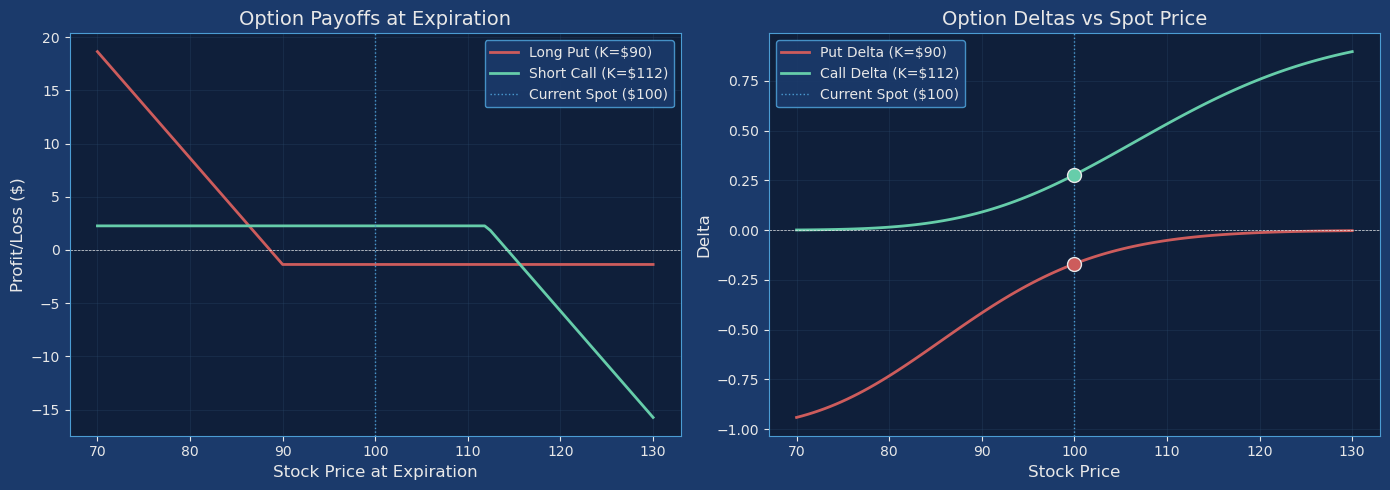

In [22]:
# Step 3: Calculate Prices and Deltas for these options
put_price, put_delta = black_scholes(S0, K_put, T, r, sigma0, "put")
call_price, call_delta = black_scholes(S0, K_call, T, r, sigma0, "call")

print(f"Option Pricing Results:")
print(f"Put (Strike ${K_put:.2f}): Price=${put_price:.2f}, Delta={put_delta:.3f}")
print(f"Call (Strike ${K_call:.2f}): Price=${call_price:.2f}, Delta={call_delta:.3f}")

# Visualize the option positions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot option payoffs at expiration
spot_range = np.linspace(70, 130, 100)
put_payoff = np.maximum(K_put - spot_range, 0) - put_price
call_payoff = -(np.maximum(spot_range - K_call, 0) - call_price)

axes[0].plot(spot_range, put_payoff, label=f'Long Put (K=${K_put:.0f})', linewidth=2, color='#CD5C5C')
axes[0].plot(spot_range, call_payoff, label=f'Short Call (K=${K_call:.0f})', linewidth=2, color='#66CDAA')
axes[0].axhline(0, color='#E8E8E8', linewidth=0.5, linestyle='--')
axes[0].axvline(S0, color='#4B9CD3', linewidth=1, linestyle=':', label=f'Current Spot (${S0:.0f})')
axes[0].set_title('Option Payoffs at Expiration', fontsize=14)
axes[0].set_xlabel('Stock Price at Expiration', fontsize=12)
axes[0].set_ylabel('Profit/Loss ($)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot option deltas vs spot price
spot_range_delta = np.linspace(70, 130, 100)
put_deltas = [black_scholes(s, K_put, T, r, sigma0, "put")[1] for s in spot_range_delta]
call_deltas = [black_scholes(s, K_call, T, r, sigma0, "call")[1] for s in spot_range_delta]

axes[1].plot(spot_range_delta, put_deltas, label=f'Put Delta (K=${K_put:.0f})', linewidth=2, color='#CD5C5C')
axes[1].plot(spot_range_delta, call_deltas, label=f'Call Delta (K=${K_call:.0f})', linewidth=2, color='#66CDAA')
axes[1].axhline(0, color='#E8E8E8', linewidth=0.5, linestyle='--')
axes[1].axvline(S0, color='#4B9CD3', linewidth=1, linestyle=':', label=f'Current Spot (${S0:.0f})')
axes[1].scatter([S0], [put_delta], s=100, color='#CD5C5C', zorder=5, edgecolors='#E8E8E8', linewidth=1)
axes[1].scatter([S0], [call_delta], s=100, color='#66CDAA', zorder=5, edgecolors='#E8E8E8', linewidth=1)
axes[1].set_title('Option Deltas vs Spot Price', fontsize=14)
axes[1].set_xlabel('Stock Price', fontsize=12)
axes[1].set_ylabel('Delta', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
# Step 4: Build the Portfolio
# We Buy 1 Put, Sell 1 Call.
pos_put = 1
pos_call = -1

print(f"Portfolio Positions:")
print(f"Long {pos_put} Put(s) at strike ${K_put:.2f}")
print(f"Short {abs(pos_call)} Call(s) at strike ${K_call:.2f}")


Portfolio Positions:
Long 1 Put(s) at strike $90.00
Short 1 Call(s) at strike $112.00


In [24]:
# Step 5: Calculate Total Delta of Options
# Net Delta = (1 * Put_Delta) + (-1 * Call_Delta)
# Put Delta is negative (~-0.25). Call Delta is positive (~0.25).
# Net Delta will be around -0.50. This means we are "Short" the market via options.
net_option_delta = (pos_put * put_delta) + (pos_call * call_delta)

print(f"Delta Calculation:")
print(f"Put Delta: {put_delta:.3f} × {pos_put} = {pos_put * put_delta:.3f}")
print(f"Call Delta: {call_delta:.3f} × {pos_call} = {pos_call * call_delta:.3f}")
print(f"Net Option Delta: {net_option_delta:.3f}")
print(f"\nInterpretation: Net Delta of {net_option_delta:.3f} means we are 'Short' the market via options.")


Delta Calculation:
Put Delta: -0.169 × 1 = -0.169
Call Delta: 0.278 × -1 = -0.278
Net Option Delta: -0.447

Interpretation: Net Delta of -0.447 means we are 'Short' the market via options.


Delta Hedging:
Net Option Delta: -0.447
Shares to Buy: 0.447 shares
Total Portfolio Delta: 0.000 (should be ~0)


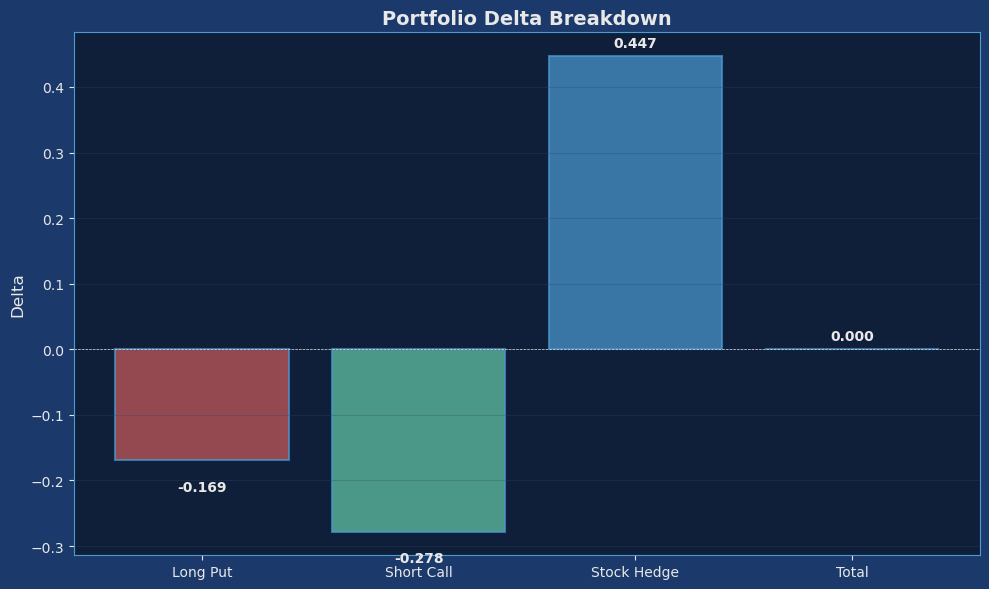

In [25]:
# Step 6: Delta Hedge
# To be 'Delta Neutral' (Zero directional risk initially), we must BUY shares.
# If Option Delta is -0.50, we buy +0.50 shares.
shares_held = -net_option_delta

print(f"Delta Hedging:")
print(f"Net Option Delta: {net_option_delta:.3f}")
print(f"Shares to Buy: {shares_held:.3f} shares")
print(f"Total Portfolio Delta: {net_option_delta + shares_held:.3f} (should be ~0)")

# Visualize the portfolio structure
fig, ax = plt.subplots(figsize=(10, 6))
positions = ['Long Put', 'Short Call', 'Stock Hedge', 'Total']
deltas = [pos_put * put_delta, pos_call * call_delta, shares_held, net_option_delta + shares_held]
colors = ['#CD5C5C', '#66CDAA', '#4B9CD3', '#E8E8E8']
bars = ax.bar(positions, deltas, color=colors, alpha=0.7, edgecolor='#4B9CD3', linewidth=1.5)
ax.axhline(0, color='#E8E8E8', linewidth=0.5, linestyle='--')
ax.set_title('Portfolio Delta Breakdown', fontsize=14, fontweight='bold')
ax.set_ylabel('Delta', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, delta) in enumerate(zip(bars, deltas)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.03),
            f'{delta:.3f}', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')
plt.tight_layout()
plt.show()


In [26]:
# Define function to calculate portfolio value under new market conditions
def calculate_portfolio_value(S_new, sigma_new, time_passed=0.0):
    """
    Calculates the PnL of our portfolio under new market conditions.
    
    Parameters:
    S_new: New stock price
    sigma_new: New volatility
    time_passed: Time that has passed (default 0.0)
    
    Returns:
    total_pnl, pnl_put, pnl_call, pnl_stock, new_put_price, new_call_price
    """
    T_new = T - time_passed
    
    # 1. Re-price the Put
    new_put_price, _ = black_scholes(S_new, K_put, T_new, r, sigma_new, "put")
    
    # 2. Re-price the Call
    new_call_price, _ = black_scholes(S_new, K_call, T_new, r, sigma_new, "call")
    
    # 3. Calculate Value of Options Position
    # (New Price - Old Price) * Quantity
    pnl_put = (new_put_price - put_price) * pos_put
    pnl_call = (new_call_price - call_price) * pos_call
    
    # 4. Calculate Value of Stock Hedge
    # (New Stock Price - Old Stock Price) * Shares Held
    pnl_stock = (S_new - S0) * shares_held
    
    total_pnl = pnl_put + pnl_call + pnl_stock
    return total_pnl, pnl_put, pnl_call, pnl_stock, new_put_price, new_call_price

print("Portfolio valuation function defined.")
print("This function will calculate PnL for different market scenarios.")


Portfolio valuation function defined.
This function will calculate PnL for different market scenarios.


### Simulating Market Moves (The "Vanna" Effect)

The speaker discusses the relationship (covariance) between spot and volatility. Instead of looking at just two discrete scenarios, let's visualize the entire "terrain" of PnL across all combinations of spot and volatility moves.

**The Key Insight:**
> *"Let's say that you have a big sell-off with a huge vol spike. You're going to make a bunch of money... because you get long Vega."*
> *"Let's say that you have a sell-off... but implied volatility... actually goes down... you're going to lose money."*

We'll create a **PnL Heatmap** showing:
- **X-Axis**: Spot price moves (-10% to +10%)
- **Y-Axis**: Volatility moves (-5 points to +10 points)
- **Color**: Portfolio PnL at each intersection

This will highlight the "profit quadrant" (Spot Down + Vol Up) versus the "pain quadrant" (Spot Down + Vol Down).

In [27]:
# Step 7: Generate PnL Heatmap
# Create a grid of spot and volatility moves to visualize the entire "terrain"

# Define ranges
spot_move_pct = np.linspace(-0.10, 0.10, 41)  # -10% to +10% in 0.5% increments
vol_move_points = np.linspace(-0.05, 0.10, 31)  # -5 points to +10 points in 0.5 point increments

# Create meshgrid
spot_moves, vol_moves = np.meshgrid(spot_move_pct, vol_move_points)

# Calculate new spot prices and volatilities
S_new_grid = S0 * (1 + spot_moves)
sigma_new_grid = sigma0 + vol_moves

# Initialize PnL grid
pnl_grid = np.zeros_like(spot_moves)

# Calculate PnL for each combination
print("Calculating PnL for all spot-vol combinations...")
for i in range(len(vol_move_points)):
    for j in range(len(spot_move_pct)):
        pnl, _, _, _, _, _ = calculate_portfolio_value(S_new_grid[i, j], sigma_new_grid[i, j])
        pnl_grid[i, j] = pnl

print(f"PnL grid shape: {pnl_grid.shape}")
print(f"Min PnL: ${pnl_grid.min():.2f}")
print(f"Max PnL: ${pnl_grid.max():.2f}")
print(f"Mean PnL: ${pnl_grid.mean():.2f}")


Calculating PnL for all spot-vol combinations...
PnL grid shape: (31, 41)
Min PnL: $-2.42
Max PnL: $1.12
Mean PnL: $-0.21


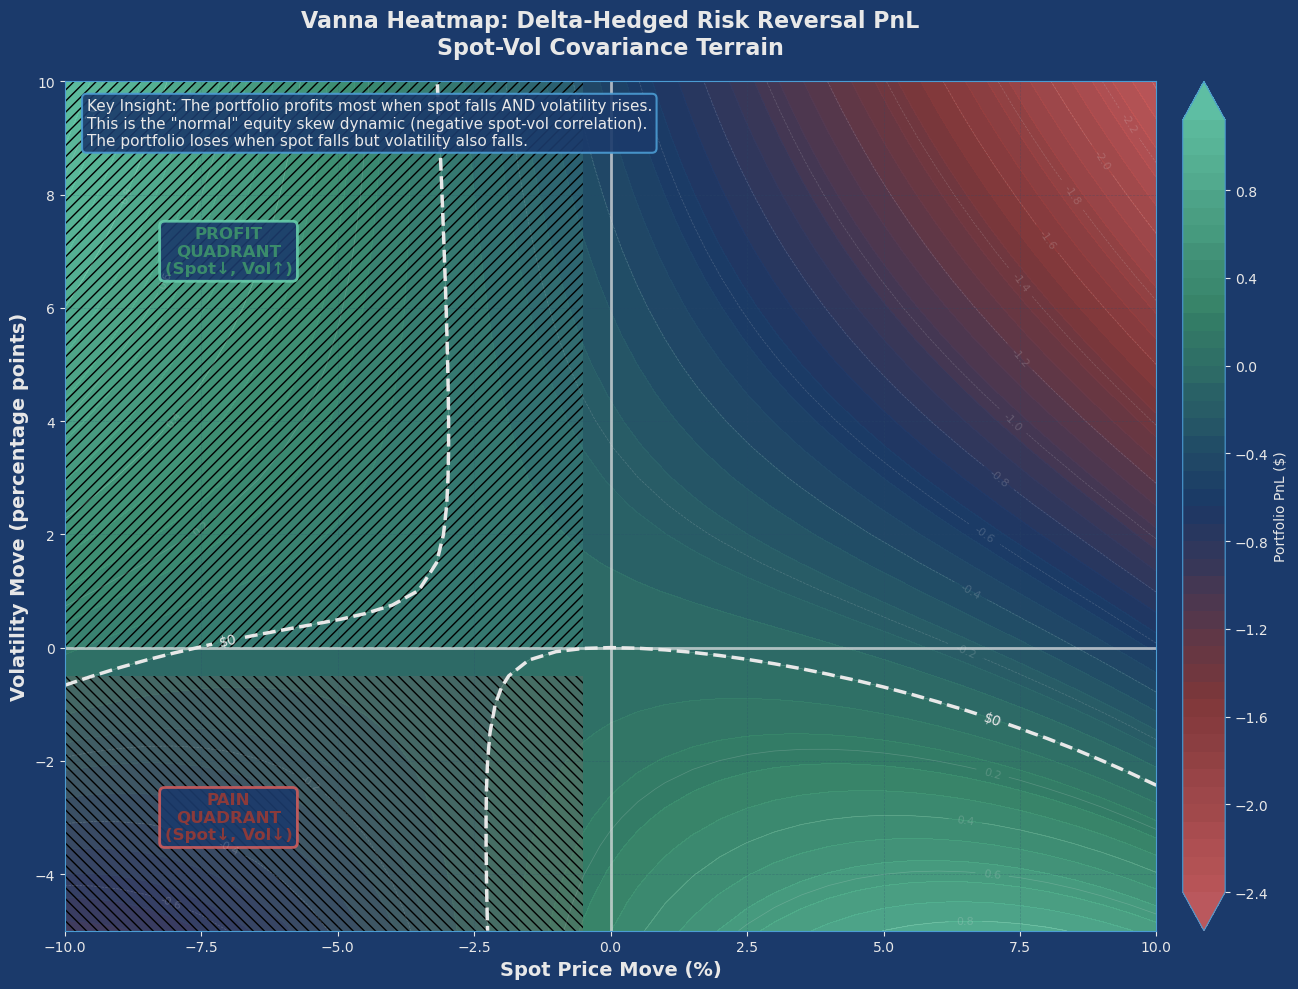


HEATMAP STATISTICS
Maximum PnL: $1.12 (at Spot=-10.0%, Vol=10.0 pts)
Minimum PnL: $-2.42 (at Spot=10.0%, Vol=10.0 pts)

Profit Quadrant (Spot↓, Vol↑):
  Average PnL: $0.20
  Max PnL: $1.12
  % Positive: 68.3%

Pain Quadrant (Spot↓, Vol↓):
  Average PnL: $-0.18
  Min PnL: $-0.76
  % Negative: 79.5%


In [28]:
# Step 8: Create the PnL Heatmap Visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Create custom colormap for dark mode: red (loss) -> navy (neutral) -> green (profit)
from matplotlib.colors import LinearSegmentedColormap
colors_list = ['#CD5C5C', '#8B3A3A', '#1B3A6B', '#3A8B6B', '#66CDAA']
n_bins = 100
cmap_custom = LinearSegmentedColormap.from_list('dark_pnl', colors_list, N=n_bins)

# Create the heatmap
im = ax.contourf(spot_moves * 100, vol_moves * 100, pnl_grid, 
                 levels=50, cmap=cmap_custom, alpha=0.9, extend='both')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, label='Portfolio PnL ($)', pad=0.02)
cbar.ax.tick_params(labelsize=10)

# Add contour lines for better readability
contour_lines = ax.contour(spot_moves * 100, vol_moves * 100, pnl_grid, 
                          levels=20, colors='#E8E8E8', alpha=0.2, linewidths=0.5)
ax.clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f', colors='#E8E8E8')

# Highlight zero PnL line
zero_contour = ax.contour(spot_moves * 100, vol_moves * 100, pnl_grid, 
                          levels=[0], colors='#E8E8E8', linewidths=2.5, linestyles='--')
ax.clabel(zero_contour, inline=True, fontsize=10, fmt='$0', colors='#E8E8E8')

# Add quadrant dividers
ax.axvline(0, color='#E8E8E8', linewidth=2, linestyle='-', alpha=0.7)
ax.axhline(0, color='#E8E8E8', linewidth=2, linestyle='-', alpha=0.7)

# Highlight the "Profit Quadrant" (Spot Down + Vol Up)
# Bottom-left quadrant: Spot < 0, Vol > 0
profit_mask = (spot_moves < 0) & (vol_moves > 0)
if profit_mask.any():
    ax.contourf(spot_moves * 100, vol_moves * 100, 
               np.where(profit_mask, 1, np.nan), 
               levels=[0.5, 1.5], colors=['#66CDAA'], alpha=0.15, hatches=['///'])

# Highlight the "Pain Quadrant" (Spot Down + Vol Down)
# Bottom-left quadrant: Spot < 0, Vol < 0
pain_mask = (spot_moves < 0) & (vol_moves < 0)
if pain_mask.any():
    ax.contourf(spot_moves * 100, vol_moves * 100, 
               np.where(pain_mask, 1, np.nan), 
               levels=[0.5, 1.5], colors=['#CD5C5C'], alpha=0.15, hatches=['\\\\\\'])

# Add quadrant labels
ax.text(-7, 7, 'PROFIT\nQUADRANT\n(Spot↓, Vol↑)', 
        fontsize=12, fontweight='bold', color='#3A8B6B',
        bbox=dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#66CDAA', linewidth=2),
        ha='center', va='center')

ax.text(-7, -3, 'PAIN\nQUADRANT\n(Spot↓, Vol↓)', 
        fontsize=12, fontweight='bold', color='#8B3A3A',
        bbox=dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#CD5C5C', linewidth=2),
        ha='center', va='center')

# Formatting
ax.set_xlabel('Spot Price Move (%)', fontsize=14, fontweight='bold')
ax.set_ylabel('Volatility Move (percentage points)', fontsize=14, fontweight='bold')
ax.set_title('Vanna Heatmap: Delta-Hedged Risk Reversal PnL\n' + 
             'Spot-Vol Covariance Terrain', 
             fontsize=16, fontweight='bold', pad=20)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

# Add text annotation explaining the key insight
textstr = ('Key Insight: The portfolio profits most when spot falls AND volatility rises.\n'
          'This is the "normal" equity skew dynamic (negative spot-vol correlation).\n'
          'The portfolio loses when spot falls but volatility also falls.')
props = dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#4B9CD3', linewidth=1.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, color='#E8E8E8')

plt.tight_layout()
plt.show()

# Print key statistics
print("\n" + "="*70)
print("HEATMAP STATISTICS")
print("="*70)
max_idx = np.unravel_index(pnl_grid.argmax(), pnl_grid.shape)
min_idx = np.unravel_index(pnl_grid.argmin(), pnl_grid.shape)
print(f"Maximum PnL: ${pnl_grid.max():.2f} (at Spot={spot_moves[max_idx]*100:.1f}%, Vol={vol_moves[max_idx]*100:.1f} pts)")
print(f"Minimum PnL: ${pnl_grid.min():.2f} (at Spot={spot_moves[min_idx]*100:.1f}%, Vol={vol_moves[min_idx]*100:.1f} pts)")

# Calculate quadrant statistics
profit_quadrant_pnl = pnl_grid[(spot_moves < 0) & (vol_moves > 0)]
pain_quadrant_pnl = pnl_grid[(spot_moves < 0) & (vol_moves < 0)]

if len(profit_quadrant_pnl) > 0:
    print(f"\nProfit Quadrant (Spot↓, Vol↑):")
    print(f"  Average PnL: ${profit_quadrant_pnl.mean():.2f}")
    print(f"  Max PnL: ${profit_quadrant_pnl.max():.2f}")
    print(f"  % Positive: {(profit_quadrant_pnl > 0).sum() / len(profit_quadrant_pnl) * 100:.1f}%")

if len(pain_quadrant_pnl) > 0:
    print(f"\nPain Quadrant (Spot↓, Vol↓):")
    print(f"  Average PnL: ${pain_quadrant_pnl.mean():.2f}")
    print(f"  Min PnL: ${pain_quadrant_pnl.min():.2f}")
    print(f"  % Negative: {(pain_quadrant_pnl < 0).sum() / len(pain_quadrant_pnl) * 100:.1f}%")
print("="*70)


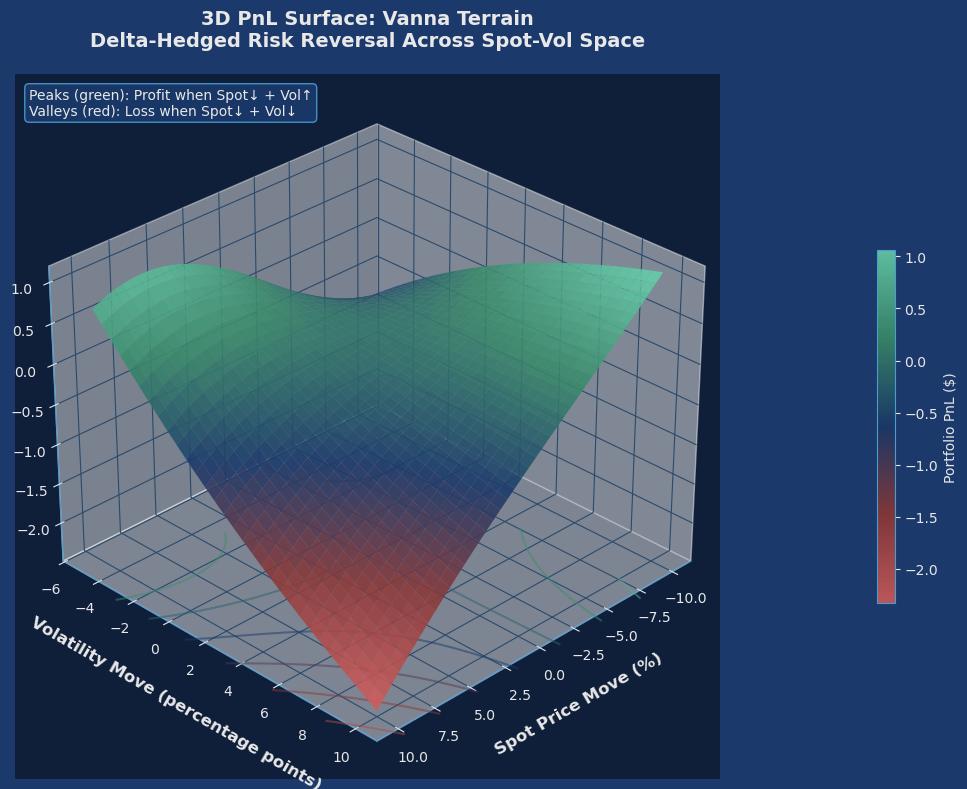

In [29]:
# Step 9: Create a 3D Surface Plot for Additional Perspective
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

# Create custom colormap for dark mode
colors_list = ['#CD5C5C', '#8B3A3A', '#1B3A6B', '#3A8B6B', '#66CDAA']
n_bins = 100
cmap_custom = LinearSegmentedColormap.from_list('dark_pnl', colors_list, N=n_bins)

# Create the 3D surface
surf = ax.plot_surface(spot_moves * 100, vol_moves * 100, pnl_grid,
                       cmap=cmap_custom, alpha=0.9, linewidth=0, antialiased=True,
                       edgecolor='none', shade=True)

# Add colorbar
cbar = plt.colorbar(surf, ax=ax, shrink=0.5, aspect=20, label='Portfolio PnL ($)', pad=0.1)
cbar.ax.tick_params(labelsize=10)

# Add contour lines on the base
ax.contour(spot_moves * 100, vol_moves * 100, pnl_grid, 
          zdir='z', offset=pnl_grid.min() - 0.5, cmap=cmap_custom, alpha=0.5)

# Highlight zero plane
zero_level = np.zeros_like(spot_moves)
ax.contour(spot_moves * 100, vol_moves * 100, zero_level,
          zdir='z', offset=0, colors='#E8E8E8', linewidths=2, linestyles='--', alpha=0.7)

# Formatting
ax.set_xlabel('Spot Price Move (%)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_ylabel('Volatility Move (percentage points)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_zlabel('Portfolio PnL ($)', fontsize=12, fontweight='bold', labelpad=10)
ax.set_title('3D PnL Surface: Vanna Terrain\n' + 
             'Delta-Hedged Risk Reversal Across Spot-Vol Space', 
             fontsize=14, fontweight='bold', pad=20)

# Set viewing angle for better perspective
ax.view_init(elev=30, azim=45)

# Add text annotation
textstr = ('Peaks (green): Profit when Spot↓ + Vol↑\n'
          'Valleys (red): Loss when Spot↓ + Vol↓')
ax.text2D(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#1B3A6B', alpha=0.9, edgecolor='#4B9CD3', linewidth=1),
         color='#E8E8E8')

plt.tight_layout()
plt.show()


### Why did this happen?

In the transcript, Content creator Benn Eifert says: *"Your first order exposure is to Vanna or spot-vol covariance."*

1.  **Long Put:** When the market crashes, you become **Long Vega** (you want volatility to go up).
2.  **Short Call:** When the market crashes, you move away from the call strike, so your short Vega exposure decreases.

So, in a crash, your portfolio *becomes* a bet that Volatility will rise.
* If Volatility DOES rise (Standard Skew), you win (Scenario A).
* If Volatility DOES NOT rise (Flat/Inverted Skew), you lose (Scenario B).

This confirms Content creator Benn Eifert's point: Skew is simply the market pricing in the correlation between Spot price and Volatility.